In [14]:
%pylab inline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [15]:
im_1 = imread("data/CalibIm1.gif")
im_2 = imread("data/CalibIm2.gif")
im_3 = imread("data/CalibIm3.gif")
im_4 = imread("data/CalibIm4.gif")
im_5 = imread("data/CalibIm5.gif")

undistort_im_1 = imread("data/UndistortIm1.gif")
undistort_im_2 = imread("data/UndistortIm2.gif")

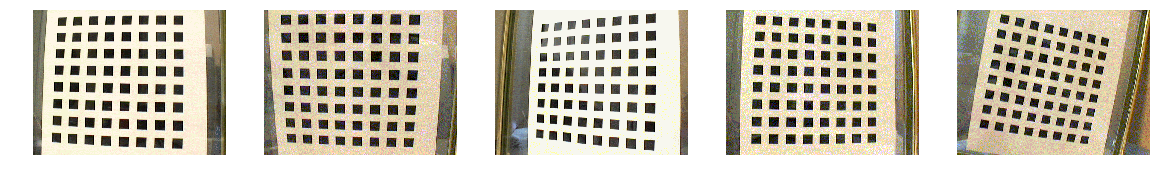

In [16]:
fig = figure(figsize=(20, 20))
for (index, image) in enumerate([im_1, im_2, im_3, im_4, im_5]):
    ax = fig.add_subplot(1, 5, index + 1)
    ax.axis('off')
    ax.imshow(image)

In [17]:
data_1 = np.loadtxt("data/data1.txt")
data_2 = np.loadtxt("data/data2.txt")
data_3 = np.loadtxt("data/data3.txt")
data_4 = np.loadtxt("data/data4.txt")
data_5 = np.loadtxt("data/data5.txt")

model = np.loadtxt("data/Model.txt")

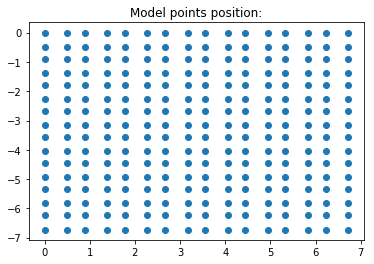

In [18]:
def chess_piece_to_points(model):
    return np.vstack((model[:, :2], model[:, 2:4], model[:, 4:6], model[:, 6:]))

model_corner_points = chess_piece_to_points(model)

title("Model points position:")
scatter(model_corner_points[:, 0], model_corner_points[:, 1])

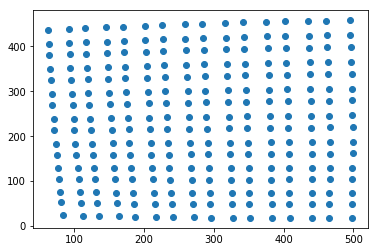

In [19]:
data_1_corner_points = chess_piece_to_points(data_1)
scatter(data_1_corner_points[:, 0], data_1_corner_points[:, 1])


In [20]:
def load_camera_calibrations():
    Calib = open("data/Calib.txt", "r").readlines()

    (a, c, b, u0, v0) = np.fromstring(Calib[0], sep=' ')

    Intrinsic = np.array([
        [a, c, u0],
        [0, b, v0],
        [0, 0,  1]
    ])

    K1, K2 = np.fromstring(Calib[2], sep=' ')

    Extrinsics = [] 

    for Start in range(4, len(Calib), 5):
        Data = np.array(map(lambda x: np.fromstring(x, sep=' '), Calib[Start:Start+4]))
        Extrinsic = np.zeros((3, 4))
        Extrinsic[:, :3] = Data[:3, :]
        Extrinsic[:, 3] = Data[3, :]

        Extrinsics.append(Extrinsic)
        
    return Intrinsic, Extrinsics, K1, K2

Intrinsic, Extrinsics, K1, K2 = load_camera_calibrations()

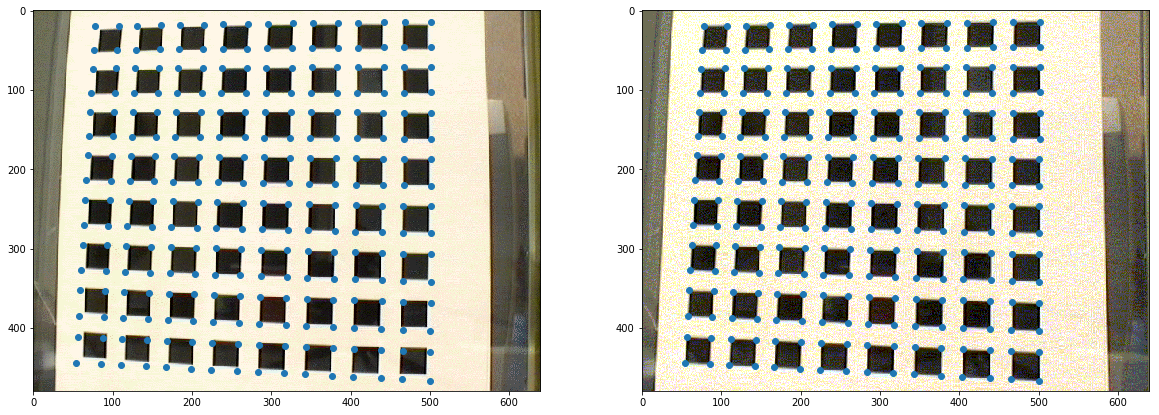

In [21]:
def reproject_3d(points3d_hom, projection_mat):
    projected_2d = np.dot(projection_mat, points3d_hom.T).T
    projected_2d /= np.repeat(projected_2d[:, 2], 3).reshape((projected_2d.shape[0], 3))
    return projected_2d

model_corner_points_padded = np.pad(model_corner_points, (0, 2), "constant", constant_values=((), (0, 1)))[:-2, :]

Projection_1 = np.dot(Intrinsic, Extrinsics[0])
Reprojected_1 = reproject_3d(model_corner_points_padded, Projection_1)

fig_1 = figure(figsize=(20, 20))
ax1_1 = fig_1.add_subplot(1, 2, 1)
ax1_1.imshow(im_1)
ax1_1.scatter(Reprojected_1[:, 0], Reprojected_1[:, 1])
ax2_1 = fig_1.add_subplot(1, 2, 2)
ax2_1.imshow(undistort_im_1)
ax2_1.scatter(Reprojected_1[:, 0], Reprojected_1[:, 1])

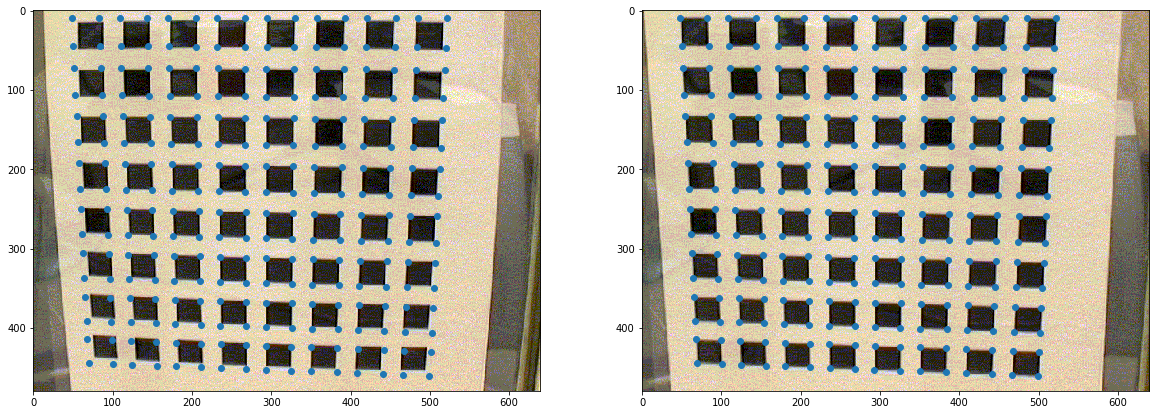

In [22]:
Projection_2 = np.dot(Intrinsic, Extrinsics[1])
Reprojected_2 = reproject_3d(model_corner_points_padded, Projection_2)

fig_2 = figure(figsize=(20, 20))
ax1_2 = fig_2.add_subplot(1, 2, 1)
ax1_2.imshow(im_2)
ax1_2.scatter(Reprojected_2[:, 0], Reprojected_2[:, 1])
ax2_2 = fig_2.add_subplot(1, 2, 2)
ax2_2.imshow(undistort_im_2)
ax2_2.scatter(Reprojected_2[:, 0], Reprojected_2[:, 1])

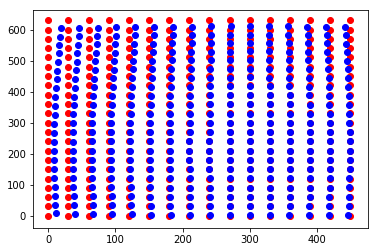

In [23]:
from scipy.ndimage.interpolation import map_coordinates

def coord_list(img):
    x, y = np.meshgrid(np.arange(img.shape[0]), np.arange(img.shape[1]))
    return np.stack((x,y), axis=2).reshape((-1,2), order='F')

def radial_distortion(points, k1, k2):
    x_y_2 = np.sum(points ** 2, axis=1)    
    x = points[:, 0] + points[:, 0] * ((k1 * x_y_2) + k2 * x_y_2 ** 2)
    y = points[:, 1] + points[:, 1] * ((k1 * x_y_2) + k2 * x_y_2 ** 2)
    return np.hstack((x[:, None], y[:, None]))

def warp(coords, H):
    coords_hom = np.hstack((coords, np.ones((coords.shape[0], 1))))
    
    result = np.dot(H, coords_hom.T).T
    return result[:, :2] / result[:, 2, None]

coords = coord_list(im_1).reshape((im_1.shape[0], im_1.shape[1], 2))
distorted = warp(
    radial_distortion(
        warp(coord_list(im_1), np.linalg.inv(Intrinsic)), 
        K1, K2
    ),
    Intrinsic
).reshape((im_1.shape[0], im_1.shape[1], 2))

scatter(coords[::30, ::30, 0], coords[::30,::30, 1], c='r')
scatter(distorted[::30, ::30, 0], distorted[::30, ::30, 1], c='b')


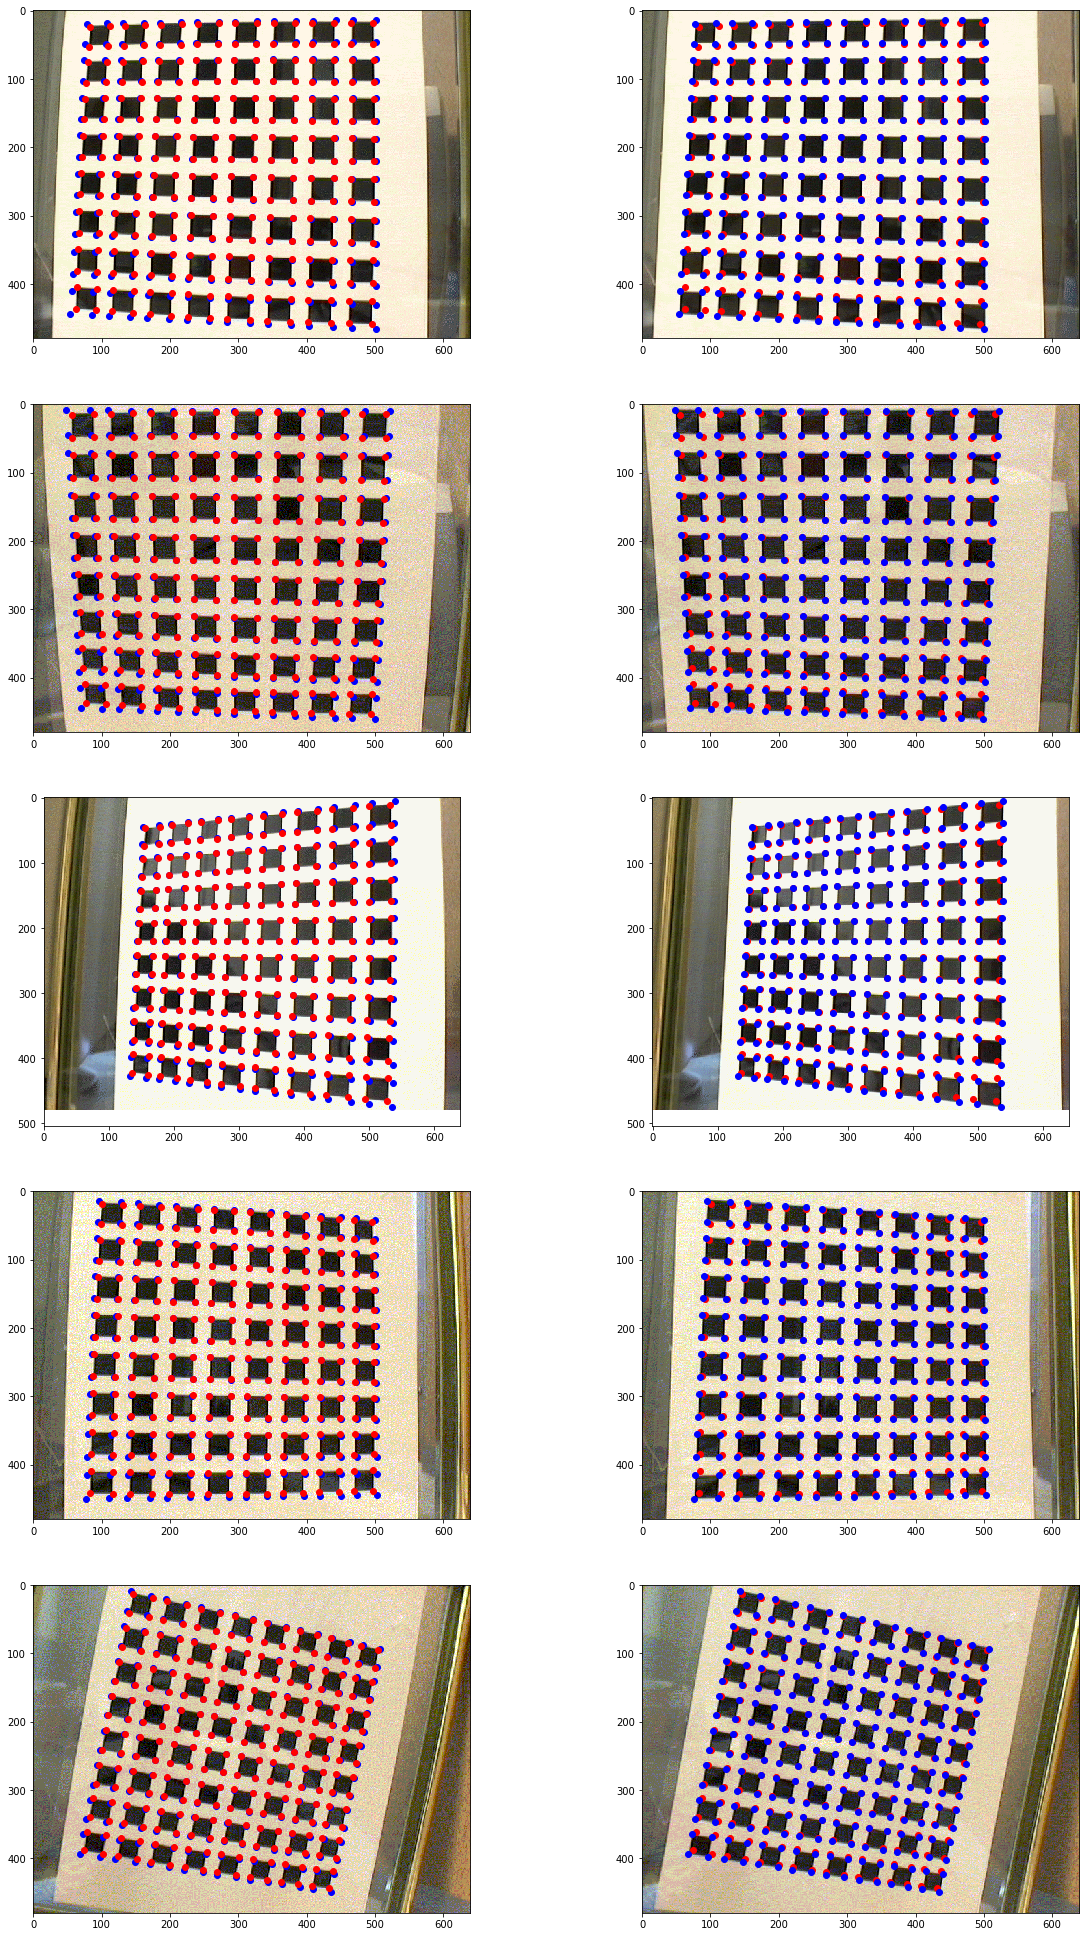

In [24]:
def undistort(img, Intrinsic, K1, K2):
    coords = coord_list(img)
    distorted = np.fliplr(warp(
        radial_distortion(
            warp(np.fliplr(coord_list(img)), np.linalg.inv(Intrinsic)), 
            K1, K2
        ),
        Intrinsic
    ))
    
    d_r = np.hstack((distorted, 2*np.ones((distorted.shape[0], 1))))
    d_g = np.hstack((distorted, np.ones((distorted.shape[0], 1))))
    d_b = np.hstack((distorted, np.zeros((distorted.shape[0], 1))))
    d_a = np.hstack((distorted, 3*np.ones((distorted.shape[0], 1))))
    
    pts_r = map_coordinates(img, d_r.T, order=3)
    pts_g = map_coordinates(img, d_g.T, order=3)
    pts_b = map_coordinates(img, d_b.T, order=3)
    pts_a = map_coordinates(img, d_a.T, order=3)
        
    new_img = np.vstack((pts_b, pts_g, pts_r, pts_a)).T
    new_img = new_img.reshape(img.transpose(1,0,2).shape, order='F').transpose((1,0,2))
    
    return new_img

fig = figure(figsize=(20, 35))

model_corner_points_noz = np.hstack((model_corner_points, np.zeros((model_corner_points.shape[0], 1))))
for (index, im) in enumerate([im_1, im_2, im_3, im_4, im_5]):
    undistorted_pts = reproject_3d(model_corner_points_padded, np.dot(Intrinsic, Extrinsics[index]))
    distorted_pts = warp(
        radial_distortion(warp(model_corner_points_noz, Extrinsics[index])[:, :2], K1, K2),
        Intrinsic
    )   
    
    uim = undistort(im, Intrinsic, K1, K2)    
    ax = fig.add_subplot(5, 2, 1 + (index * 2))
    ax.imshow(im)
    ax.scatter(undistorted_pts[:, 0], undistorted_pts[:, 1], c='b')
    ax.scatter(distorted_pts[:, 0], distorted_pts[:, 1], c='r')
    ax2 = fig.add_subplot(5, 2, 1 + (index * 2 + 1))
    ax2.imshow(uim)    
    ax2.scatter(distorted_pts[:, 0], distorted_pts[:, 1], c='r')
    ax2.scatter(undistorted_pts[:, 0], undistorted_pts[:, 1], c='b')
    

In [62]:
dist_1_pts = chess_piece_to_points(data_1)
dist_2_pts = chess_piece_to_points(data_2)
dist_3_pts = chess_piece_to_points(data_3)
dist_4_pts = chess_piece_to_points(data_4)
dist_5_pts = chess_piece_to_points(data_5)

model_corner_points_z = np.hstack((model_corner_points, np.zeros((model_corner_points.shape[0], 1))))

# World coordinate points (shifted by rotation/translation of cameras.)
xys = np.vstack([warp(model_corner_points_z, E) for E in Extrinsics])
# Ideal points:
uvs = np.vstack([warp(warp(model_corner_points_z, E), Intrinsic) for E in Extrinsics])
# Distorted points:
dist_uvs = np.vstack((dist_1_pts, dist_2_pts, dist_3_pts, dist_4_pts, dist_5_pts))

u_u0 = uvs[:, 0] - Intrinsic[0, 2]
v_v0 = uvs[:, 1] - Intrinsic[1, 2]
xy_2 = np.sum(xys ** 2, axis=1)

D = np.zeros((2*5*64*4, 2))
d = np.zeros((2*5*64*4, 1))
D[::2, 0] = u_u0 * xy_2 
D[::2, 1] = u_u0 * xy_2**2 
D[1::2, 0] = v_v0 * xy_2 
D[1::2, 1] = v_v0 * xy_2**2

d[::2, 0] = dist_uvs[:, 0] - uvs[:, 0]
d[1::2, 0] = dist_uvs[:, 1] - uvs[:, 1]

K1_, K2_ = np.linalg.lstsq(D, d[:,0])[0]

print K1 - K1_, K2 - K2_

-2.1708155060529144e-05 0.00014516115621665548


/home/killavus/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


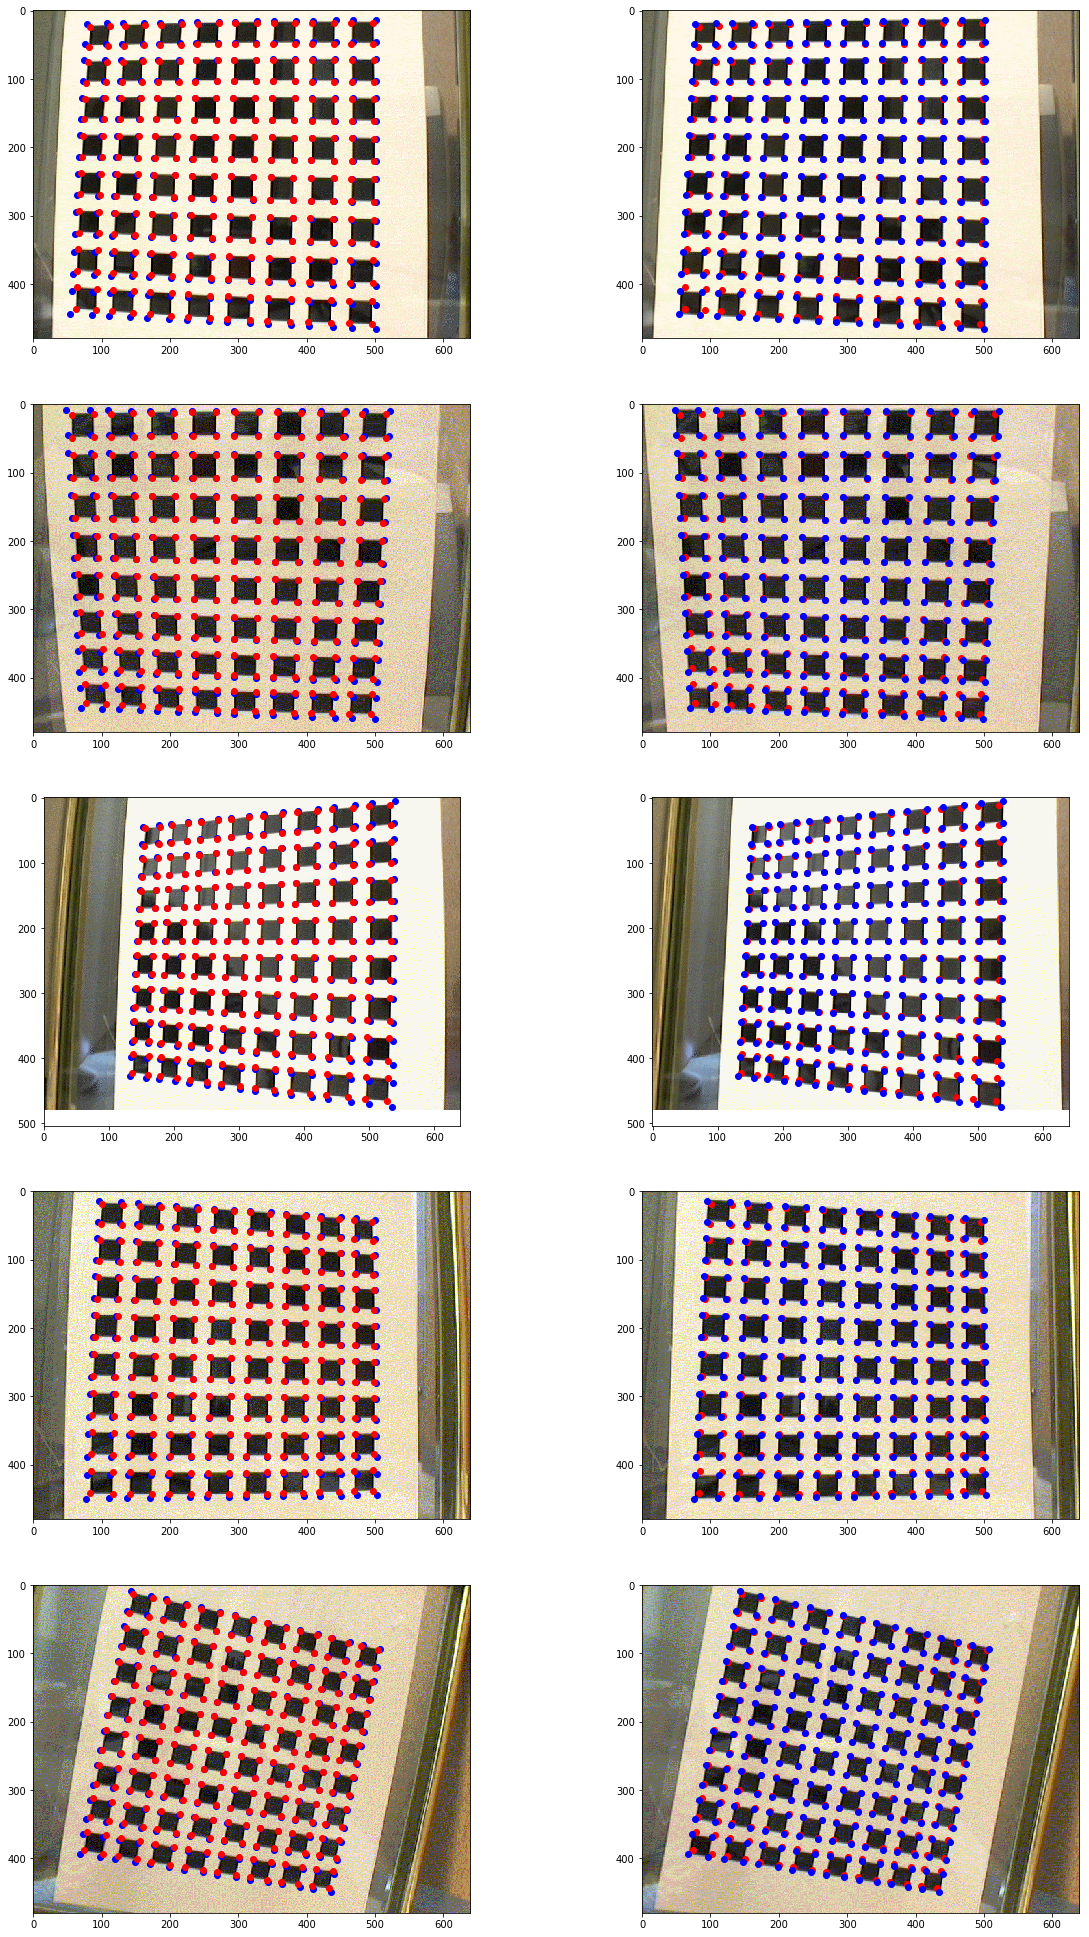

In [61]:
fig = figure(figsize=(20, 35))
for (index, im) in enumerate([im_1, im_2, im_3, im_4, im_5]):
    undistorted_pts = reproject_3d(model_corner_points_padded, np.dot(Intrinsic, Extrinsics[index]))
    distorted_pts = warp(
        radial_distortion(warp(model_corner_points_noz, Extrinsics[index])[:, :2], K1_, K2_),
        Intrinsic
    )
    
    uim = undistort(im, Intrinsic, K1_, K2_)    
    ax = fig.add_subplot(5, 2, 1 + (index * 2))
    ax.imshow(im)
    ax.scatter(undistorted_pts[:, 0], undistorted_pts[:, 1], c='b')
    ax.scatter(distorted_pts[:, 0], distorted_pts[:, 1], c='r')
    ax2 = fig.add_subplot(5, 2, 1 + (index * 2 + 1))
    ax2.imshow(uim)    
    ax2.scatter(distorted_pts[:, 0], distorted_pts[:, 1], c='r')
    ax2.scatter(undistorted_pts[:, 0], undistorted_pts[:, 1], c='b')
